Project Title: "Advanced Image Classification using Pre-trained Convolutional Neural Networks with CIFAR-10 Dataset"
Problem Statement:
How can we leverage pre-trained Convolutional Neural Networks (CNNs) such as VGG-16, ResNet, and Inception to effectively classify images from the CIFAR-10 dataset, and compare the performance of these models when fine-tuned, modified, and trained using various techniques including freezing layers, adjusting network heads, and saving intermediate models?

cuda:0
Files already downloaded and verified
Files already downloaded and verified


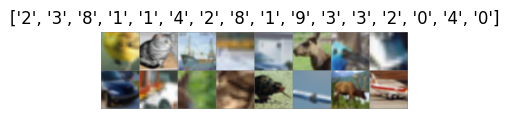

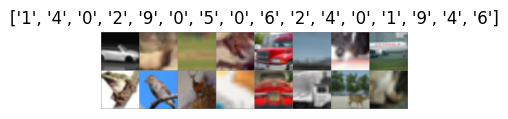

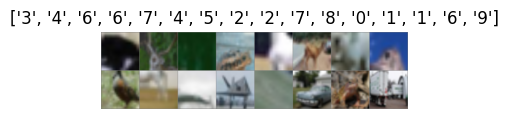

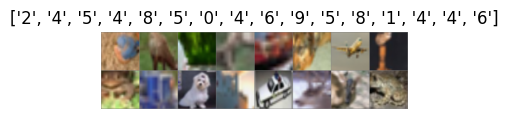

Iteration: 0/3125, Loss: 2.39
Iteration: 100/3125, Loss: 2.46
Iteration: 200/3125, Loss: 2.30
Iteration: 300/3125, Loss: 2.26
Iteration: 400/3125, Loss: 2.41
Iteration: 500/3125, Loss: 2.25
Iteration: 600/3125, Loss: 2.20
Iteration: 700/3125, Loss: 2.19
Iteration: 800/3125, Loss: 2.21
Iteration: 900/3125, Loss: 2.08
Iteration: 1000/3125, Loss: 2.19
Iteration: 1100/3125, Loss: 2.54
Iteration: 1200/3125, Loss: 2.44
Iteration: 1300/3125, Loss: 2.19
Iteration: 1400/3125, Loss: 2.12
Iteration: 1500/3125, Loss: 2.30
Iteration: 1600/3125, Loss: 2.33
Iteration: 1700/3125, Loss: 2.33
Iteration: 1800/3125, Loss: 2.32
Iteration: 1900/3125, Loss: 2.15
Iteration: 2000/3125, Loss: 1.98
Iteration: 2100/3125, Loss: 2.11
Iteration: 2200/3125, Loss: 2.01
Iteration: 2300/3125, Loss: 2.08
Iteration: 2400/3125, Loss: 2.17
Iteration: 2500/3125, Loss: 2.19
Iteration: 2600/3125, Loss: 2.05
Iteration: 2700/3125, Loss: 1.80
Iteration: 2800/3125, Loss: 1.87
Iteration: 2900/3125, Loss: 2.16
Iteration: 3000/3125, 

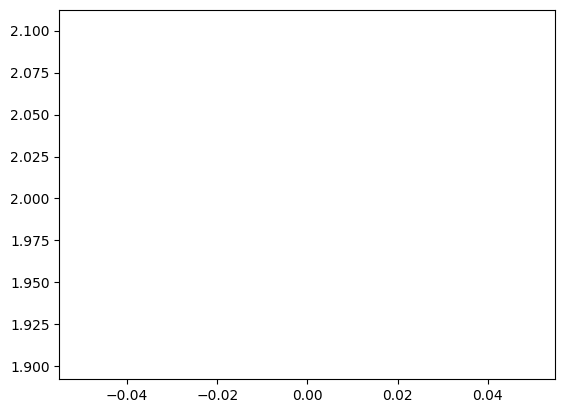

torch.Size([10, 4096])
torch.Size([10])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [1]:


import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

class CNNModels:
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.num_classes = 10
        self.batch_size = 16
        self.trainloader, self.testloader = self.load_data()
        
    def load_data(self):
        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        transform_test = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True,
                                                transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True,
                                                transform=transform_test)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=self.batch_size, shuffle=False)

        return trainloader, testloader

    def imshow(self, img, title):
        npimg = img.numpy() / 2 + 0.5
        plt.figure(figsize=(self.batch_size, 1))
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(title)
        plt.show()

    def show_batch_images(self):
        for i in range(4):
            images, labels = next(iter(self.trainloader))
            img = torchvision.utils.make_grid(images)
            self.imshow(img, title=[str(x.item()) for x in labels])

    def modify_vgg16(self):
        vgg = models.vgg16_bn()
        final_in_features = vgg.classifier[6].in_features
        mod_classifier = list(vgg.classifier.children())[:-1]
        mod_classifier.extend([nn.Linear(final_in_features, self.num_classes)])
        vgg.classifier = nn.Sequential(*mod_classifier)
        return vgg.to(self.device)

    def evaluation(self, dataloader, model):
        total, correct = 0, 0
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
        return 100 * correct / total

    def train_model(self, model, max_epochs=1, lr=0.05):
        loss_fn = nn.CrossEntropyLoss()
        opt = optim.SGD(model.parameters(), lr=lr)
        loss_epoch_arr = []
        n_iters = np.ceil(50000 / self.batch_size)

        for epoch in range(max_epochs):
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                opt.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                opt.step()

                if i % 100 == 0:
                    print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

                del inputs, labels, outputs
                torch.cuda.empty_cache()

            loss_epoch_arr.append(loss.item())
            print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
                epoch + 1, max_epochs, self.evaluation(self.testloader, model), self.evaluation(self.trainloader, model)))

        plt.plot(loss_epoch_arr)
        plt.show()
        return model

    def freeze_and_train(self, model):
        for param in model.parameters():
            param.requires_grad = False

        final_in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(final_in_features, self.num_classes)

        for param in model.parameters():
            if param.requires_grad:
                print(param.shape)

        return self.train_model(model, max_epochs=1, lr=0.05)

    def train_with_best_model(self, model, max_epochs=1):
        loss_fn = nn.CrossEntropyLoss()
        opt = optim.SGD(model.parameters(), lr=0.05)
        loss_epoch_arr = []
        min_loss = 1000
        n_iters = np.ceil(50000 / self.batch_size)

        for epoch in range(max_epochs):
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                opt.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                opt.step()

                if min_loss > loss.item():
                    min_loss = loss.item()
                    best_model = copy.deepcopy(model.state_dict())
                    print('Min loss %0.2f' % min_loss)

                if i % 100 == 0:
                    print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

                del inputs, labels, outputs
                torch.cuda.empty_cache()

            loss_epoch_arr.append(loss.item())

        model.load_state_dict(best_model)
        print(self.evaluation(self.trainloader, model), self.evaluation(self.testloader, model))
        return model

    def modify_resnet(self):
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        in_features = resnet.fc.in_features
        resnet.fc = nn.Linear(in_features, self.num_classes)
        return resnet.to(self.device)

    def modify_inception(self):
        inception = models.inception_v3(pretrained=True)
        for param in inception.parameters():
            param.requires_grad = False

        aux_in_features = inception.AuxLogits.fc.in_features
        inception.AuxLogits.fc = nn.Linear(aux_in_features, self.num_classes)
        in_features = inception.fc.in_features
        inception.fc = nn.Linear(in_features, self.num_classes)
        return inception.to(self.device)

    def train_inception(self, model, max_epochs=1):
        loss_fn = nn.CrossEntropyLoss()
        opt = optim.SGD(model.parameters(), lr=0.01)
        loss_epoch_arr = []
        min_loss = 1000
        n_iters = np.ceil(50000 / self.batch_size)

        for epoch in range(max_epochs):
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                opt.zero_grad()
                outputs, aux_outputs = model(inputs)
                loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
                loss.backward()
                opt.step()

                if min_loss > loss.item():
                    min_loss = loss.item()
                    best_model = copy.deepcopy(model.state_dict())
                    print('Min loss %0.2f' % min_loss)

                if i % 100 == 0:
                    print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

                del inputs, labels, outputs
                torch.cuda.empty_cache()

            loss_epoch_arr.append(loss.item())

        model.load_state_dict(best_model)
        print(self.evaluation(self.trainloader, model), self.evaluation(self.testloader, model))
        plt.plot(loss_epoch_arr)
        plt.show()
        return model

# Instantiate and use the class
project = CNNModels()
project.show_batch_images()

# VGG-16 model modification and training
vgg = project.modify_vgg16()
project.train_model(vgg)

# Freeze and train VGG-16
vgg = project.freeze_and_train(vgg)

# Train VGG-16 with best model saving
vgg = project.train_with_best_model(vgg)

# Modify and train ResNet
resnet = project.modify_resnet()
resnet = project.train_with_best_model(resnet)

# Modify and train Inception v3
inception = project.modify_inception()
inception = project.train_inception(inception)
